In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBClassifier

In [2]:
# ================================================================
# FEATURE IMPORTANCE ANALYSIS AND SELECTION PIPELINE
# ================================================================

def evaluate_model(X, y, model_params=None, cv_folds=5):
    """Evaluate XGBoost model using cross-validation F1 score"""
    if model_params is None:
        model_params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'random_state': 42,
            'n_jobs': -1
        }

    model = XGBClassifier(**model_params)

    # Stratified K-Fold for better evaluation
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    f1_scores = cross_val_score(model, X, y, cv=skf, scoring='f1')

    return f1_scores.mean(), f1_scores.std()

def get_feature_importance(X, y, model_params):
    """Get feature importance from XGBoost model"""
    model = XGBClassifier(**model_params)
    model.fit(X, y)

    # Get feature importance
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    return importance_df, model

def recursive_feature_elimination(X, y, model_params, min_features=5):
    """
    Perform recursive feature elimination by removing least important features one by one
    """
    current_features = X.columns.tolist()
    results = []

    print(f"\nStarting with {len(current_features)} features")
    print("Performing recursive feature elimination...")

    # Initial evaluation
    f1_score, f1_std = evaluate_model(X[current_features], y, model_params)
    results.append({
        'n_features': len(current_features),
        'f1_score': f1_score,
        'f1_std': f1_std,
        'removed_feature': None
    })
    print(f"Features: {len(current_features)}, F1: {f1_score:.4f} (+/- {f1_std:.4f})")

    best_f1 = f1_score
    best_features = current_features.copy()

    while len(current_features) > min_features:
        # Get feature importance for current features
        importance_df, _ = get_feature_importance(X[current_features], y, model_params)

        # Remove least important feature
        least_important = importance_df.iloc[-1]['feature']
        current_features.remove(least_important)

        # Evaluate with remaining features
        f1_score, f1_std = evaluate_model(X[current_features], y, model_params)

        results.append({
            'n_features': len(current_features),
            'f1_score': f1_score,
            'f1_std': f1_std,
            'removed_feature': least_important
        })

        print(f"Features: {len(current_features)}, F1: {f1_score:.4f} (+/- {f1_std:.4f}), Removed: {least_important}")

        # Track best performance
        if f1_score > best_f1:
            best_f1 = f1_score
            best_features = current_features.copy()

    return pd.DataFrame(results), best_features, best_f1

def get_features_for_count(feature_selection_results, X_train_columns, target_count):
    """Get the exact feature list for a specific feature count from recursive elimination"""
    current_features = X_train_columns.tolist()

    # Remove features in the order they were removed during recursive elimination
    for _, row in feature_selection_results.iterrows():
        if row['n_features'] < len(current_features):
            removed_feature = row['removed_feature']
            if removed_feature in current_features:
                current_features.remove(removed_feature)

            # Stop when we reach target number of features
            if len(current_features) == target_count:
                break

    return current_features

# ================================================================
# MAIN FEATURE SELECTION PIPELINE
# ================================================================

def run_feature_selection_pipeline(df_processed):
    """
    Complete Feature Importance Analysis and Selection Pipeline

    Analyzes feature importance and performs recursive feature elimination to
    identify optimal feature sets for hyperparameter optimization phase.

    Args:
        df_processed: Processed dataframe from feature engineering phase

    Returns:
        feature_selection_results: DataFrame with RFE results
        best_features: List of optimal features
        high_performing_counts: Feature counts suitable for optimization
    """
    print("🚀 FEATURE IMPORTANCE ANALYSIS & SELECTION PIPELINE")
    print("=" * 65)
    print("🎯 MISSION: IDENTIFY OPTIMAL FEATURES FOR RESCUE PREDICTION")
    print("   - XGBoost-based feature importance analysis")
    print("   - Recursive feature elimination (RFE)")
    print("   - High-performing feature set identification")
    print("   - Preparation for hyperparameter optimization")
    print("=" * 65)

    # Prepare data for feature analysis
    print("\n📊 STEP 1: DATA PREPARATION")
    print("-" * 35)

    X_train = df_processed.drop(['Transported', 'PassengerId'], axis=1, errors='ignore')
    y_train = df_processed['Transported']

    print(f"   ✅ Features extracted: {X_train.shape[1]} features")
    print(f"   ✅ Samples available: {X_train.shape[0]} passengers")
    print(f"   ✅ Target distribution: {y_train.sum()}/{len(y_train)} transported")

    # Baseline model parameters (from Yun's notebook)
    baseline_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'random_state': 42,
        'n_jobs': -1,
        'n_estimators': 100
    }

    # Step 2: Feature Importance Analysis
    print("\n🔍 STEP 2: FEATURE IMPORTANCE ANALYSIS")
    print("-" * 45)

    # Get baseline performance
    baseline_f1, baseline_std = evaluate_model(X_train, y_train, baseline_params)
    print(f"   📈 Baseline F1 Score: {baseline_f1:.4f} (+/- {baseline_std:.4f})")

    # Get initial feature importance
    importance_df, baseline_model = get_feature_importance(X_train, y_train, baseline_params)
    print(f"   ✅ Feature importance analysis complete")
    print("\n   🏆 Top 10 Most Important Features:")
    print(importance_df.head(10).to_string(index=False, float_format='%.4f'))

    # Step 3: Recursive Feature Elimination
    print(f"\n🔄 STEP 3: RECURSIVE FEATURE ELIMINATION")
    print("-" * 45)

    feature_selection_results, best_features, best_f1_score = recursive_feature_elimination(
        X_train, y_train, baseline_params, min_features=3
    )

    print(f"\n   🎯 RFE Analysis Complete:")
    print(f"   📊 Best F1 Score: {best_f1_score:.4f}")
    print(f"   📊 Optimal feature count: {len(best_features)}")
    print(f"   📊 Selected features: {best_features}")

    # Step 4: Identify High-Performing Feature Sets
    print(f"\n🎖️  STEP 4: HIGH-PERFORMING FEATURE SET IDENTIFICATION")
    print("-" * 55)

    # Find feature counts with F1 > threshold
    threshold = 0.805
    high_performing = feature_selection_results[feature_selection_results['f1_score'] > threshold].copy()
    high_performing = high_performing.sort_values('f1_score', ascending=False)

    if len(high_performing) > 0:
        print(f"   🏅 Feature counts with F1 > {threshold}:")
        print(high_performing[['n_features', 'f1_score']].to_string(index=False, float_format='%.4f'))

        feature_counts_to_optimize = high_performing['n_features'].tolist()
        print(f"\n   ✅ Selected for hyperparameter optimization: {feature_counts_to_optimize}")
        print(f"   ✅ Total feature sets to optimize: {len(feature_counts_to_optimize)}")
    else:
        # Fallback: use top 3 performing feature counts
        top_performers = feature_selection_results.nlargest(3, 'f1_score')
        feature_counts_to_optimize = top_performers['n_features'].tolist()
        print(f"   📋 No feature sets above {threshold} threshold")
        print(f"   ✅ Using top 3 performing counts: {feature_counts_to_optimize}")

    # Step 5: Visualization
    print(f"\n📈 STEP 5: FEATURE SELECTION VISUALIZATION")
    print("-" * 45)

    plt.figure(figsize=(12, 6))
    plt.plot(feature_selection_results['n_features'], feature_selection_results['f1_score'],
             marker='o', linewidth=2, markersize=6)
    plt.xlabel('Number of Features')
    plt.ylabel('F1 Score')
    plt.title('Feature Selection: F1 Score vs Number of Features')
    plt.grid(True, alpha=0.3)

    # Highlight best performance
    best_idx = feature_selection_results['f1_score'].idxmax()
    best_row = feature_selection_results.loc[best_idx]
    plt.annotate(f'Best: {best_row["n_features"]} features\nF1: {best_row["f1_score"]:.4f}',
                 xy=(best_row['n_features'], best_row['f1_score']),
                 xytext=(10, 10), textcoords='offset points',
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    plt.tight_layout()
    plt.show()

    print("   ✅ Feature selection curve plotted")

    # Final Summary
    print("\n" + "=" * 65)
    print("🎉 FEATURE SELECTION PIPELINE COMPLETE!")
    print("=" * 65)
    print(f"   📊 Analysis completed for {X_train.shape[1]} features")
    print(f"   📊 Baseline performance: {baseline_f1:.4f} F1 score")
    print(f"   📊 Best feature set: {len(best_features)} features → {best_f1_score:.4f} F1")
    print(f"   📊 Optimization candidates: {len(feature_counts_to_optimize)} feature sets")
    print(f"   🚀 Ready for hyperparameter optimization phase!")
    print("=" * 65)

    return feature_selection_results, best_features, feature_counts_to_optimize, importance_df

# ================================================================
# EXPORT FEATURE SELECTION RESULTS
# ================================================================

def export_feature_selection_results(feature_selection_results, best_features, importance_df, feature_counts_to_optimize):
    """Export feature selection results for next phase"""
    print("\n📦 EXPORTING FEATURE SELECTION RESULTS")
    print("-" * 40)

    # Export RFE results
    feature_selection_results.to_csv('data/processed/feature_selection_results.csv', index=False)
    print("   ✅ Feature selection results: feature_selection_results.csv")

    # Export best features
    pd.DataFrame({'best_features': best_features}).to_csv('../data/processed/best_features_selected.csv', index=False)
    print("   ✅ Best features list: best_features_selected.csv")

    # Export high-performing feature counts
    pd.DataFrame({'feature_counts': feature_counts_to_optimize}).to_csv('../data/processed/feature_counts_to_optimize.csv', index=False)
    print("   ✅ Optimization feature counts: feature_counts_to_optimize.csv")

    # Export feature importance
    importance_df.to_csv('data/processed/feature_importance_analysis.csv', index=False)
    print("   ✅ Feature importance: feature_importance_analysis.csv")

    # Print final feature set results
    print("\n🎯 FINAL FEATURE SET RESULTS")
    print("-" * 35)
    print(f"   📊 Best feature count: {len(best_features)}")
    print(f"   📊 Optimization candidates: {len(feature_counts_to_optimize)} feature sets")
    print(f"   📊 Feature counts for optimization: {feature_counts_to_optimize}")
    print(f"\n   🏆 SELECTED BEST FEATURES:")
    for i, feature in enumerate(best_features, 1):
        print(f"      {i:2d}. {feature}")

    print("   🚀 All results exported for hyperparameter optimization phase!")

📥 Loading processed dataset...
   ✅ Dataset loaded: (8693, 107)
🚀 FEATURE IMPORTANCE ANALYSIS & SELECTION PIPELINE
🎯 MISSION: IDENTIFY OPTIMAL FEATURES FOR RESCUE PREDICTION
   - XGBoost-based feature importance analysis
   - Recursive feature elimination (RFE)
   - High-performing feature set identification
   - Preparation for hyperparameter optimization

📊 STEP 1: DATA PREPARATION
-----------------------------------
   ✅ Features extracted: 105 features
   ✅ Samples available: 8693 passengers
   ✅ Target distribution: 4378/8693 transported

🔍 STEP 2: FEATURE IMPORTANCE ANALYSIS
---------------------------------------------
   📈 Baseline F1 Score: 0.7621 (+/- 0.0063)
   ✅ Feature importance analysis complete

   🏆 Top 10 Most Important Features:
          feature  importance
        CryoSleep      0.1440
       TotalSpend      0.1363
  PlanetFrequency      0.0877
      CabinDeck_E      0.0433
        DeckLevel      0.0409
        FoodCourt      0.0395
        Cryo_Deck      0.0317
Ho

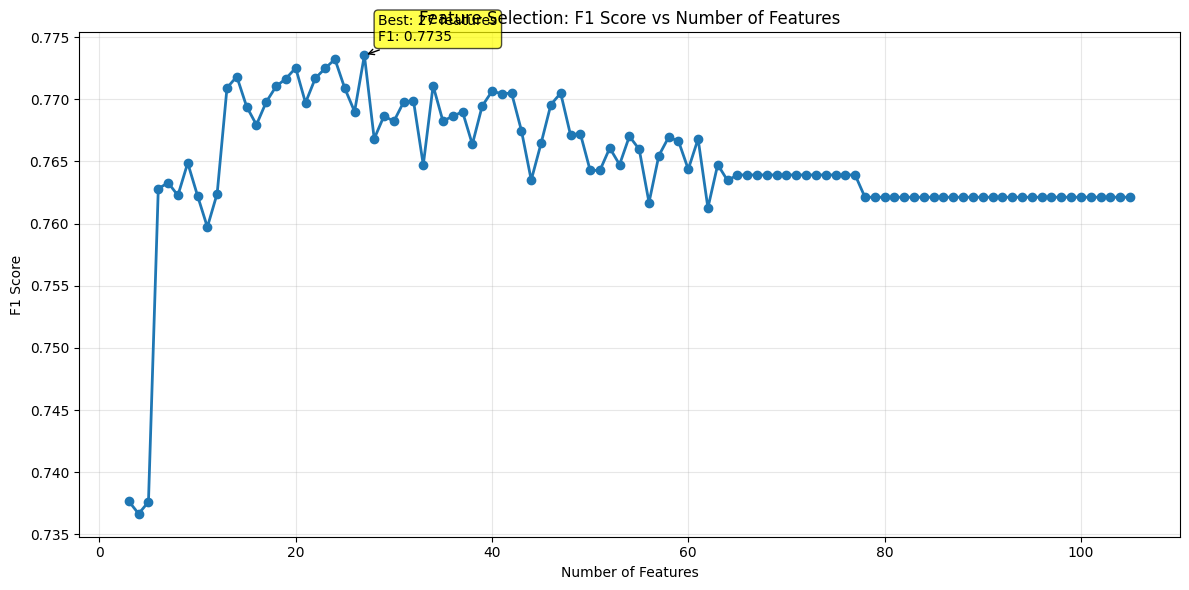

   ✅ Feature selection curve plotted

🎉 FEATURE SELECTION PIPELINE COMPLETE!
   📊 Analysis completed for 105 features
   📊 Baseline performance: 0.7621 F1 score
   📊 Best feature set: 27 features → 0.7735 F1
   📊 Optimization candidates: 3 feature sets
   🚀 Ready for hyperparameter optimization phase!


In [5]:
# ================================================================
# EXECUTE FEATURE SELECTION PIPELINE
# ================================================================

# Load processed dataset
print("📥 Loading processed dataset...")
df_processed_train = pd.read_csv('train_dataset_spaceship_titanic_processed.csv')
print(f"   ✅ Dataset loaded: {df_processed_train.shape}")

# Run feature selection pipeline
feature_selection_results, best_features, feature_counts_to_optimize, importance_df = run_feature_selection_pipeline(df_processed_train)

# Export results
# export_feature_selection_results(feature_selection_results, best_features, importance_df, feature_counts_to_optimize)